# Disseration Experiment 6h
# Generate DICE Output (Credit Card Fraud) - Experiment Jan 5¶
Ciaran Finnegan January 2024

# Import Libraries + Custom Functions

## Import Libraries

In [1]:
# Import libs
import numpy as np
import pandas as pd

# Display libraries
from IPython.display import display, HTML
from prettytable import PrettyTable
import raiutils
from raiutils.exceptions import UserConfigValidationException


# Import necessary libraries for DICE explainer
import dice_ml
from dice_ml.utils import helpers  # helper functions


# Import necessary libraries for NN Modelling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Libraries required for metrics calculations
from scipy.spatial import distance
from sklearn.cluster import KMeans


# Libraries for Supplementary Model Evaluation
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample


# Classifier training (not used for explainability)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Libraries used in Experiment Creation of XL Output Metrics
import os
import time
import random
import openpyxl

## Custom Functions

Dataset Visualisations

In [2]:
%run ./DS_Visualisation_Functions.ipynb

Metrics

In [3]:
%run ./XAI_Metrics_Functions.ipynb

Function 'example_function' executed in 2.0021 seconds
Result: Result, Execution Time: 2.002119302749634 seconds


Model Evaluation Functions

In [4]:
%run ./DS_Model_Build_Evaluation_Functions.ipynb

Track Experiment Result Functions

In [5]:
%run ./XAI_Experiment_Functions.ipynb

# Load Model

A Neural Network Model has been created in another Kubeflow Notebook and is being used in all the XAI experiments

In [6]:
loaded_model = keras.models.load_model('ccfraud_model')  # If saved as SavedModel

In [7]:
X_test_loaded, y_test_loaded, df_downsampled_loaded, dfCatCols = load_CC_train_test_data()

In [8]:
#dfCatCols

## Re-Display Model Peformance

For illustration, the evualtion metrics of the NN model will be repeated here.

### Tabular Data

In [9]:
scaler = StandardScaler()   
X_test_loaded_scaled = scaler.fit_transform(X_test_loaded)

In [10]:
y_pred_loaded = display_model_metrics_tabular(loaded_model, X_test_loaded_scaled, y_test_loaded)

42/42 [==============================] - 0s 1ms/step - loss: 0.3934 - accuracy: 0.8516


42/42 [==============================] - 0s 915us/step


Metric,Value
Accuracy,0.851598
ROC AUC Score,0.935696
Precision (Class 0),0.919499
Recall (Class 0),0.774096
F1-Score (Class 0),0.840556
Precision (Class 1),0.801325
Recall (Class 1),0.930769
F1-Score (Class 1),0.861210


Tablular Done!


### Confusion Matrix

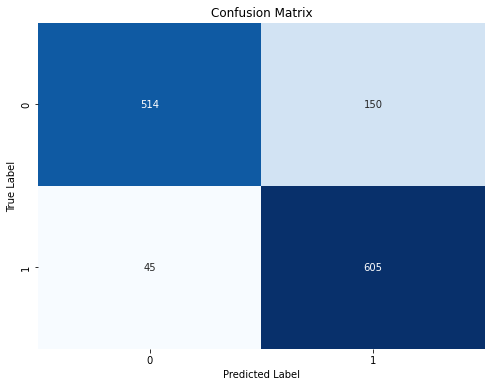

'Confusion Matrix!'

In [11]:
generate_confusion_matrix(y_test_loaded, y_pred_loaded)

# Apply DiCE

## Generate the Counterfactuals

In [12]:
#lCC_catcols_as_list = dfCatCols[dfCatCols.columns[0]].tolist()

### Use Tensor Flow - Prepare DiCE parameters - CC Dataset

#### Read External File Containing list of Continous Features

An analysis, external to this Notebook, has taken place to identify the set of continous features that will be use din this experiment to generate Counterfactual values.

In [13]:
def read_cc_features(file_path):
    # Read the CSV file
    data = pd.read_csv(file_path)
    
    # Filter the data where Rank is 39 or between 41 and 53 (inclusive)
    filtered_data = data[(data['RANK'] == 39) | ((data['RANK'] >= 41) & (data['RANK'] <= 55))]
    
    # Extract the 'Feature' column values and return them as a list
    feature_list = filtered_data['FEATURE'].tolist()
    return feature_list

In [14]:
# Assume the file is in the same directory as Notebook
file_path = 'Select_CC_Fraud_Features_v1_1.csv'
cc_continuous_features_list = read_cc_features(file_path)

In [15]:
# Display List of continous features loaded from external XL file.
cc_continuous_features_list

['AmountBase',
 'POSSum.acc.month.total',
 'NotECommerceAuthAmount.acc.day.total',
 'NonEMVTransactionsAcc.acc.day.total',
 'POSTerminalAttendedAuthAmount.acc.day.total',
 'CustomerPresentAuthAmount.acc.day.total',
 'EMVTransactionsAcc.acc.day.total',
 'CustomerNotPresentAuthAmount.acc.day.total',
 'HourlyAuthAmt.acc.hour25',
 'NonEMVTransactionsAcc.acc.day.present',
 'NotECommerceAuthAmount.acc.day.present',
 'CustomerNotPresentAuthAmount.acc.day.present',
 'POSTerminalAttendedAuthAmount.acc.day.present',
 'CustomerPresentAuthAmount.acc.day.present',
 'HighRiskPOSSum.acc.hour.total',
 'EMVTransactionsAcc.acc.day.present']

#### Build DiCE Counterfactual Function

In [16]:
# Define the data for DiCE based on your DataFrame
d = dice_ml.Data(dataframe=df_downsampled_loaded, continuous_features=cc_continuous_features_list, outcome_name='Fraud')

In [17]:
# Use the backend as TensorFlow and link the model
m = dice_ml.Model(model=loaded_model, backend='TF2')

In [18]:
# Initialize DiCE
exp = dice_ml.Dice(d, m)

#### Example 1: Sample DiCE Counterfactual example (x2)

The code below provides examples of generated counterfactuals. In the first two examples, for each instance entry the code has generated five counterfactuals.

In [19]:
# Generate counterfactual explanations
# Change query instances to match the instances you are interested in
query_instances = df_downsampled_loaded.iloc[0:2].drop('Fraud', axis=1)  # Taking the first two instances
counterfactuals = exp.generate_counterfactuals(query_instances, total_CFs=5, desired_class="opposite")

100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


In [20]:
# Visualize the counterfactual explanations
counterfactuals.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card Present,DvcPosEntryMode_E-Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y,Fraud
0,-1,0,1,5631,0,0,1,1,1,1,...,0,0,0,1,1,0,0,1,0,0



Diverse Counterfactual set (new outcome: 1)


,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card Present,DvcPosEntryMode_E-Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y,Fraud
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1
3,23,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1
4,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1


Query instance (original outcome : 0)


,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card Present,DvcPosEntryMode_E-Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y,Fraud
0,-1,0,3,5499,1,0,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0



Diverse Counterfactual set (new outcome: 1)


,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card Present,DvcPosEntryMode_E-Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y,Fraud
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,1,-,1
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1
3,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1
4,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1


------------------------

#### Example 2: Counterfactual - Highlighted Display

This example uses a display routine to improve the visual highlightin of the counterfactuals.

In [21]:
# Generate counterfactuals
#exp = dice_ml.Dice(d, m)
query_instance = df_downsampled_loaded.iloc[0:1].drop('Fraud', axis=1)

In [22]:
# Generate counterfactuals
dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=5, desired_class="opposite")

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


#### Visualize Counterfactuals (Single Set) - No Highlights

In [23]:
dice_exp.visualize_as_dataframe()

Query instance (original outcome : 0)


,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card Present,DvcPosEntryMode_E-Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y,Fraud
0,-1,0,1,5631,0,0,1,1,1,1,...,0,0,0,1,1,0,0,1,0,0



Diverse Counterfactual set (new outcome: 1)


,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card Present,DvcPosEntryMode_E-Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y,Fraud
0,-1,0,1,5631,0,0,1,1,1,1,...,0,0,0,1,1,0,0,1,0,1
1,-1,0,1,5631,0,0,12,1,1,1,...,0,0,0,1,1,0,0,1,0,1
2,-1,0,1,5631,0,0,1,1,1,1,...,0,0,0,1,1,0,0,1,0,1
3,-1,0,1,5631,0,0,1,1,1,1,...,0,0,0,1,1,0,0,1,0,1
4,-1,0,1,5631,0,0,1,1,1,1,...,0,0,0,1,1,0,0,1,0,1


#### Visualize Counterfactuals (Single Set) - With Highlights

##### Create Display Function

In [24]:
def highlight_differences(query_instance, counterfactuals_df):
    """
    Compares a query instance (as a Series) with counterfactual instances in a DataFrame.
    
    Args:
    - query_instance (pd.Series): The original data instance.
    - counterfactuals_df (pd.DataFrame): DataFrame containing counterfactual instances.
    
    Returns:
    - A styled DataFrame where:
        * The original instance is highlighted entirely.
        * Cells with differences in counterfactuals are highlighted.
    """
    # Convert query_instance to DataFrame and concatenate with counterfactuals_df
    combined_df = pd.concat([query_instance.to_frame().T, counterfactuals_df], axis=0).reset_index(drop=True)
    
    def highlight_cells(row):
        """Helper function to apply the styling."""
        if row.name == 0:  # If it's the original instance
            return ['background-color: lightblue' for _ in row.index]
        
        # For counterfactual rows
        colors = []
        for col in row.index:
            original_value = query_instance[col]
            cf_value = row[col]
            
            # Convert to the same data type if they are different
            if type(original_value) != type(cf_value):
                try:
                    original_value = type(cf_value)(original_value)
                except ValueError:
                    try:
                        cf_value = type(original_value)(cf_value)
                    except ValueError:
                        pass
            
            # Handle float comparisons with a small tolerance
            if isinstance(original_value, float) and isinstance(cf_value, float):
                if abs(original_value - cf_value) < 1e-9:
                    colors.append('')
                else:
                    colors.append('background-color: yellow')
            elif original_value != cf_value:
                colors.append('background-color: yellow')
            else:
                colors.append('')
        return colors
    
    styled_df = combined_df.style.apply(highlight_cells, axis=1)
    return styled_df

# This refined version of the function should handle potential data type mismatches better.

##### Display Differences - with Highlights

In [25]:
# 2. Extract counterfactuals to a DataFrame
your_actual_counterfactuals_df = dice_exp.cf_examples_list[0].final_cfs_df

In [26]:
#your_actual_counterfactuals_df.head()

In [27]:
query_instance_series = df_downsampled_loaded.iloc[0]

In [28]:
styled_result = highlight_differences(query_instance_series, your_actual_counterfactuals_df)

In [29]:
# 3. Visualize differences
display(styled_result)

,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,DomesticAuthCount.cnt.hour15,DomesticAuthCounter.cnt.day.present,DomesticAuthCount.cnt.hour25,OnlinePOSCountForever.cnt.present,POSTerminalAttendedAuthCount.cnt.day.present,CustomerNotPresentAuthCount.cnt.day.present,DvcVerificationCap,ECommerceAuthCount.cnt.day.present,OnlineNewMerchCtryCntDaily.cnt.day.present,OnlineNewMerchCtryCntHourly.cnt.hour24,OnlineNewMerchCtryCntHourly.cnt.hour15,OnlineNewMerchCtryCntHourly.cnt.hour10,OnlineNewMerchCtryCntHourly.cnt.hour3,OnlineNewMerchCtryCntHourly.cnt.hour4,OnlineNewMerchCtryCntDaily.cnt.day.total,NotECommerceAuthCount.cnt.day.present,NewMerchantCountryCount.cnt.hour15,OnlineNewMerchCtryCntHourly.cnt.hour1,NewMerchantCountryCount.cnt.hour10,NewMerchantCountryCount.cnt.hour24,NewMerchantCountryCount.cnt.hour4,NewMerchantCountryCount.cnt.hour3,AuthResponse,NewMerchantCountryCount.cnt.hour1,AmountBase,CardType,POSSum.acc.month.total,NotECommerceAuthAmount.acc.day.total,NonEMVTransactionsAcc.acc.day.total,POSTerminalAttendedAuthAmount.acc.day.total,CustomerPresentAuthAmount.acc.day.total,EMVTransactionsAcc.acc.day.total,CustomerNotPresentAuthAmount.acc.day.total,HourlyAuthAmt.acc.hour25,NonEMVTransactionsAcc.acc.day.present,NotECommerceAuthAmount.acc.day.present,CustomerNotPresentAuthAmount.acc.day.present,POSTerminalAttendedAuthAmount.acc.day.present,CustomerPresentAuthAmount.acc.day.present,HighRiskPOSSum.acc.hour.total,EMVTransactionsAcc.acc.day.present,Fraud,PosTerminalAttended_N,PosTerminalAttended_U,PosTerminalAttended_Y,TxnChannelCode_OnL,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card Present,DvcPosEntryMode_E-Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y
0,-1,0,1,5631,0,0,1,1,1,1,1,1,1,-19,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,203,819,2300,14880,20450,13948,7355,0,13095,203,203,203,0,203,203,0,0,1,0,0,1,1,0,0,0,1,1,0,0,1,0
1,-1,0,1,5631,0,0,1,1,1,1,1,1,1,-19,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,203,819,2300,14880,36461,13948,7355,0,13095,203,203,203,0,203,203,0,0,1,0,0,1,1,0,0,0,1,1,0,0,1,0
2,-1,0,1,5631,0,0,12,1,1,1,1,1,1,-19,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,203,819,2300,14880,20450,13948,7355,0,13095,203,203,203,11285,203,203,0,0,1,0,0,1,1,0,0,0,1,1,0,0,1,0
3,-1,0,1,5631,0,0,1,1,1,1,1,1,1,-19,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,203,819,2300,14880,20450,13948,7355,0,13095,203,203,203,0,7563,203,0,0,1,0,0,1,1,0,0,0,1,1,0,0,1,0
4,-1,0,1,5631,0,0,1,1,1,1,1,1,1,-19,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,203,819,2300,14880,20450,13948,7355,0,13095,203,203,203,0,5762,203,0,0,1,0,0,1,1,0,0,0,1,1,0,0,1,0
5,-1,0,1,5631,0,0,1,1,1,1,1,1,1,-19,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,203,819,2300,14880,20450,13948,7355,0,13095,203,203,203,0,9062,203,0,0,1,0,0,1,1,0,0,0,1,1,0,0,1,0


# Prepare Data for Metric Calculations

### Prepare DiCE input to Metrics function

In [30]:
@timeit
def generate_counterfactuals_for_instances(df, num_instances=20, sLabel='Fraud'):
    """
    Generate counterfactual explanations for a specified number of instances from a dataframe.
    
    Args:
    - df (pd.DataFrame): The dataframe containing the original instances.
    - num_instances (int): The number of instances for which to generate counterfactuals.
    
    Returns:
    - original_instances_df (pd.DataFrame): DataFrame containing the original instances.
    - counterfactuals_df (pd.DataFrame): DataFrame containing the counterfactual explanations.
    """
    # Prepare an empty dataframe for counterfactuals
    counterfactuals_list = []
    
    # Select the first 'num_instances' from the dataframe
    original_instances_df = df.head(num_instances)
    
    for _, instance in original_instances_df.iterrows():
        # Convert the instance to DataFrame
        
        instance_df = instance.drop(sLabel).to_frame().T
        #instance_df = instance.drop('default').to_frame().T
        #instance_df = instance.to_frame().T
        
        # Generate counterfactual for the instance
        dice_exp = exp.generate_counterfactuals(instance_df, total_CFs=1, desired_class="opposite")
        
        # Extract the counterfactual to a DataFrame
        cf_df = dice_exp.cf_examples_list[0].final_cfs_df.drop(sLabel, axis=1)
        #cf_df = dice_exp.cf_examples_list[0].final_cfs_df.drop('default', axis=1)
        #cf_df = dice_exp.cf_examples_list[0].final_cfs_df
        
        # Append the counterfactual to the list
        counterfactuals_list.append(cf_df.iloc[0])
    
    counterfactuals_df = pd.DataFrame(counterfactuals_list).reset_index(drop=True)
    
    return original_instances_df, counterfactuals_df

In [31]:
# Dec 29 - use df_downsampled instead of df_encoded
# df_encoded
#df_downsampled
#df_downsampled_loaded

In [32]:
# Extract the feature names, excluding the target variable 'default'
#column_names = df_downsampled_loaded.drop('Fraud', axis=1).columns

In [33]:
# Execute the function for the first 20 instances of 'df_encoded'
#results, exec_time = generate_counterfactuals_for_instances(df_downsampled_loaded)

In [34]:
# Unpack the results to get df_instances and df_shap_values
#df_instances, df_shap_values = results
#original_df, cf_df = results

### Determine Computational Efficiency Value

In [35]:
# Display time to generate DiCE explainers
#print(f"Dice Execution Time: {exec_time} seconds")

In [36]:
#original_df

In [37]:
#cf_df

# Generate XAI Metrics 

## Identity

#### Run a Basic Test First

In [38]:
#scaler = StandardScaler()

In [39]:
#original_df = scaler.fit_transform(original_df)

In [40]:
#cf_df = scaler.fit_transform(cf_df)

In [41]:
# Extract the feature names, including the target variable 'Fraud'
#column_names_wDefault = df_downsampled_loaded.columns

In [42]:
# Convert NumPy array to DataFrame
#original_df = pd.DataFrame(original_df, columns=column_names_wDefault)

In [43]:
# Convert NumPy array to DataFrame
#cf_df = pd.DataFrame(cf_df, columns=column_names)

In [44]:
#original_df.head()

In [45]:
#cf_df.head()

In [46]:
# Select two random instances from the DiCE dataframe
#df_xai_numerical = cf_df

#random_indices = np.random.choice(df_xai_numerical.index, size=2, replace=False)
#instance_1 = df_xai_numerical.iloc[random_indices[0]]
#instance_2 = df_xai_numerical.iloc[random_indices[1]]

# Compute the Euclidean distance between the selected instances - uses custom project function
#distance = get_euclidean_distance(instance_1, instance_2)
#print(f"Euclidean distance between instance {random_indices[0]} and instance {random_indices[1]}: {distance:.4f}")

#### Retrieve Identity Score

In [47]:
# Convert all values to float for consistent data type
#original_df = original_df.astype(float)
#cf_df = cf_df.astype(float)

In [48]:
#from scipy.spatial import distance

In [49]:
#DiCE_Identity_Metric = get_identity_metric(original_df, cf_df, "DiCE")

#### Display Identity Score Metric

In [50]:
#DiCE_Ident_Number = "{:.2f}%".format(DiCE_Identity_Metric)

In [51]:
#display_text("DiCE Identity Metric Score: " + DiCE_Ident_Number)

## Stability

### Invoke Stability Metric Function

#### Retrieve Stability Score

In [52]:
#DiCE_Stability_Metric = get_stability_metric_y(cf_df, y_test_downsampled, 'DiCE')
#DiCE_Stability_Metric = get_stability_metric_y(cf_df, y_test_loaded, 'DiCE')

#### Display Stability Score Metric

In [53]:
#DiCE_Stbly_Number = "{:.2f}%".format(DiCE_Stability_Metric)
#display_text("DiCE Stability Metric Score: " + DiCE_Stbly_Number)

## Seperability

### Invoke Seperability Metric Function

#### Retrieve Seperability Score

In [54]:
#DiCE_Seperability_Metric = get_seperability_metric(original_df, cf_df, "DiCE")

In [55]:
#DiCE_Seperability_Number = "{:.2f}%".format(DiCE_Seperability_Metric)
#display_text("DiCE Seperability Metric Score: " + DiCE_Seperability_Number)

## Similarity

### Invoke Similarity Metric Function

#### Retrieve Similarity Score

In [56]:
#DiCE_Similarity_Metric = get_similarity_metric(original_df, cf_df, "DiCE", use_dbscan=False)

In [57]:
#DiCE_Similarity_Number = "{:6.2f}".format(DiCE_Similarity_Metric)
#display_text("DiCE Similarity Metric Value: " + DiCE_Similarity_Number)

# XAI Experiments - Metrics Capture

## Suppress Warnings to clean up output

In [58]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

## Break out Model Test Data into a list of dataframes

### Create Test Data for Experiment Inout

In [59]:
#X_test_loaded.head()

In [60]:
#y_test_loaded.head()

In [61]:
#X_test_loaded.shape

Step 1: Ensure 'X_test' and 'y_test' Are DataFrames with Proper Columns

In [62]:
# Assuming 'X_test' is a numpy array and you have a list of the original column names
original_feature_names = [col for col in df_downsampled_loaded.columns if col != 'Fraud']

# Ensure X_test_loaded has the correct column names (if necessary)
X_test_loaded.columns = original_feature_names

In [63]:
#X_test_loaded

In [64]:
#y_test_loaded.head()

In [65]:
# Combine X_test_loaded and y_test into a single DataFrame
df_TestData = pd.concat([X_test_loaded, y_test_loaded], axis=1)

In [66]:
#df_TestData.head()

### Split the DataFrame into 20 consecutive smaller DataFrames

In [67]:
# Split the DataFrame into 20 consecutive smaller DataFrames
split_size, list_df = split_TestData_into_nn_Blocks(df_TestData, num_splits = 20)

Original DF Length: 1314
Split Size: 65


In [68]:
# Count the occurrence of each unique value in the 'Fraud' column
fraud_counts = df_TestData['Fraud'].value_counts()

# Display the counts
print("Breakdown of 'Fraud' and non-Fraud label records in df_TestData:")
print(fraud_counts)

Breakdown of 'Fraud' and non-Fraud label records in df_TestData:
0    664
1    650
Name: Fraud, dtype: int64


### Add a routine to check output values

In [69]:
# Display starting points in the first nn sub dataframes
startBlockDisplay(df_TestData, split_size, 1)

,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card Present,DvcPosEntryMode_E-Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y,Fraud
0,1,0,1,5541,1,0,1,1,1,1,...,1,0,0,1,1,0,0,1,0,1


## Confirm Starting Point in External XL File

Now, write additional Python code so that for each dataframe in the list just created carry out the following actions;

Check if an XAI results XL spreadsheet called 'XAI_Metrics_Expriments.xls' exists;

If not create an empty XL spreadsheet with the name 'XAI_Metrics_Expriments.xls', and then define a variable called ‘Sample’ with an integer value of 1 and print the value of 'Sample' to output.

If and XL spreadsheet called 'XAI_Metrics_Expriments.xls' does exist, then read the entries in the spreadsheet in the first column named ‘Sample Number’ and create a variable 
in this Python program named ‘Sample’ that is one integer value higher than the highest integer number column named ‘Sample Number’ in the XL, and print this value of 'Sample' to output.

In [70]:
# Create a sequential number as an identifier for each DataFrame
list_df = {f'df_{i + 1}': list_df[i] for i in range(len(list_df))}

In [71]:
# File path for the XAI results spreadsheet
DiCE_xai_file_path = 'DICE_XAI_Metrics_Experiments.xlsx'  # Stored locally

In [72]:
# Call Function to update or create the spreadsheet and determine the 'Sample' number
# Process each dataframe in 'list_df'
sample = return_next_sample_number_to_process(list_df, DiCE_xai_file_path, "DiCE")

Sample Number for current DiCE XAI DataFrame: 4


## Select Next Dataframe to Process

---------------------------------

	
Extend the Python code so that the code reads in the dataframe from 'list df' that corresponds to the integer value in the 
variable named ‘Sample’. 

Assign this dataframe the name 'df_Selected_from_List'.


----------------------------------

### Initialize Dataframe to Capture Re-start Point as None

In [73]:
# Initialize df_Selected_from_List as None
df_Selected_from_List = None

### Extract test data block to restart XAI metrics process

In [74]:
df_Selected_from_List, key = select_restart_testdata_block(df_Selected_from_List, 
                                                           list_df, 
                                                           DiCE_xai_file_path)

DataFrame selected for Sample Number 4 witk key df_4


In [75]:
# If no DataFrame is selected (e.g., if 'Sample' exceeds the number of DataFrames in list_df)
if 'df_Selected_from_List' not in locals():
    print("No DataFrame selected. The 'Sample' number may exceed the number of DataFrames in list_df.")

------------------------------------

## Generate XAI Metrics from Dataframe

In [76]:
#df_Selected_from_List

### Generate the Counterfactuals for the Test Data Block

In [77]:
results_DiCE, exec_time_Dice = generate_counterfactuals_for_instances(df_Selected_from_List)

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

Function 'generate_counterfactuals_for_instances' executed in 21.6471 seconds


In [78]:
original_df_DiCE, cf_df_DiCE = results_DiCE

### Generate Identity Metric

#### Pre-Process Identity Inputs

In [79]:
scaler = StandardScaler()

In [80]:
original_df_DiCE = scaler.fit_transform(original_df_DiCE)

In [81]:
cf_df_DiCE = scaler.fit_transform(cf_df_DiCE)

In [82]:
# Extract the feature names, including the target variable 'Fraud'
column_names_wDefault = df_downsampled_loaded.columns

In [83]:
# Convert NumPy array to DataFrame
original_df_DiCE = pd.DataFrame(original_df_DiCE, columns=column_names_wDefault)

In [85]:
column_names = df_downsampled_loaded.drop('Fraud', axis=1).columns

In [86]:
# Convert NumPy array to DataFrame
cf_df_DiCE = pd.DataFrame(cf_df_DiCE, columns=column_names)

In [87]:
# Convert all values to float for consistent data type
original_df_DiCE = original_df_DiCE.astype(float)
cf_df_DiCE = cf_df_DiCE.astype(float)

#### Retrieve Identity Score

In [88]:
DiCE_Identity_Metric = get_identity_metric(original_df_DiCE, cf_df_DiCE, "DiCE")

Instance 0:   Current matches: 0
	Closest feature instance: 3 (Distance: 8.5225)
	Closest DiCE instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 1:   Current matches: 1
	Closest feature instance: 16 (Distance: 5.5591)
	Closest DiCE instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 2:   Current matches: 2
	Closest feature instance: 10 (Distance: 3.6679)
	Closest DiCE instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 3:   Current matches: 2
	Closest feature instance: 10 (Distance: 5.1922)
	Closest DiCE instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 4:   Current matches: 3
	Closest feature instance: 11 (Distance: 3.6404)
	Closest DiCE instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 5:   Current matches: 4
	Closest feature instance: 14 (Distance: 8.9583)
	Closest DiCE instance: {closest_xai_idx} (Distance: {

#### Display Identity Score Metric

In [89]:
DiCE_Ident_Number = "{:.2f}%".format(DiCE_Identity_Metric)

In [90]:
display_text("DiCE Identity Metric Score: " + DiCE_Ident_Number)

In [91]:
# Read in XAI Metric for Identity
XAI_Ident_Metric_1 = DiCE_Identity_Metric

----------------------------------

### Generate Stability Metric

#### Retrieve Stability Score

In [93]:
DiCE_Stability_Metric = get_stability_metric_y(cf_df_DiCE, y_test_loaded, 'DiCE')

Number of Instances in Cluster '0': 12
Number of Instances in Cluster '1': 8

For Class '0':
Total Instances: 9
Matching Cluster '0' Instances: 4

For Class '1':
Total Instances: 11
Matching Cluster '1' Instances: 3


This is the function in XAI_METRICS_FUNCTIONS -- STABILITY -- DiCE



Percentage of matches: 44.44%   44.44444444444444 Matches of 20 Entries


#### Display Stability Score Metric

In [94]:
DiCE_Stbly_Number = "{:.2f}%".format(DiCE_Stability_Metric)

In [95]:
display_text("DiCE Stability Metric Score: " + DiCE_Stbly_Number)

In [96]:
# Read in XAI Metric for Stability
XAI_Stability_Metric_2 = DiCE_Stability_Metric

-----------------------------

### Generate Seperability Metric

#### Retrieve Seperability Score

In [97]:
DiCE_Seperability_Metric = get_seperability_metric(original_df_DiCE, cf_df_DiCE, "DiCE")

#### Display Seperability Score Metric

In [98]:
DiCE_Seperability_Number = "{:.2f}%".format(DiCE_Seperability_Metric)

In [99]:
display_text("DiCE Seperability Metric Score: " + DiCE_Seperability_Number)

In [100]:
# Read in XAI Metric for Seperability
XAI_Seperability_Metric_3 = DiCE_Seperability_Metric

----------------------------

### Generate Similarity Metric

#### Retrieve Similarity Score

In [101]:
DiCE_Similarity_Metric = get_similarity_metric(original_df_DiCE, cf_df_DiCE, "DiCE", use_dbscan=False)

#### Display Similarity Score Metric

In [102]:
DiCE_Similarity_Number = "{:6.2f}".format(DiCE_Similarity_Metric)

In [103]:
display_text("DiCE Similarity Metric Value: " + DiCE_Similarity_Number)

In [104]:
# Read in XAI Metric for Similarity
XAI_Similarity_Metric_4 = DiCE_Similarity_Metric

-------------------------------

### Display Final Set of Metric (this run)

In [105]:
# Print the results
print(f"XAI Ident Metric 1: {XAI_Ident_Metric_1}")
print(f"XAI Stability Metric 2: {XAI_Stability_Metric_2}")
print(f"XAI Seperability Metric 1: {XAI_Seperability_Metric_3}")
print(f"XAI Similarity Metric 1: {XAI_Similarity_Metric_4}")
print(f"XAI Time Metric 5: {exec_time_Dice} seconds")

XAI Ident Metric 1: 85.0
XAI Stability Metric 2: 44.44444444444444
XAI Seperability Metric 1: 100.0
XAI Similarity Metric 1: 6.861681260072164
XAI Time Metric 5: 21.647136926651 seconds


------------------------------------

## Write Out Metrics to XL

In [106]:
print(type(df_Selected_from_List))

<class 'pandas.core.frame.DataFrame'>


In [107]:
write_xai_Metrics_to_XL(DiCE_xai_file_path, 
                        sample, 
                        DiCE_Identity_Metric, 
                        DiCE_Stability_Metric, 
                        DiCE_Seperability_Metric, 
                        DiCE_Similarity_Metric, 
                        exec_time_Dice, 
                        df_Selected_from_List)

DiCE DataFrame selected for Sample Number 4 witk key df_4
